In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

import gensim

import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
nltk.download('stopwords')

Using TensorFlow backend.
C:\Users\asus\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
decode_map = {0: "NORMAL", 1: "DEPRESSED"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [46]:
df=pd.read_csv('Cap/tot_his.csv', delimiter = ',',encoding='utf-8')

In [5]:
df.Depressed = df.Depressed.apply(lambda x: decode_sentiment(x))

In [6]:
len(df)

69544

In [7]:
df['Subreddit'].nunique()

8572

In [8]:
df['Username'].nunique()

4479

In [9]:
df.Subreddit.value_counts().head()

depression        5184
whowouldwin       2682
AskReddit         2648
legaladvice        730
Showerthoughts     656
Name: Subreddit, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

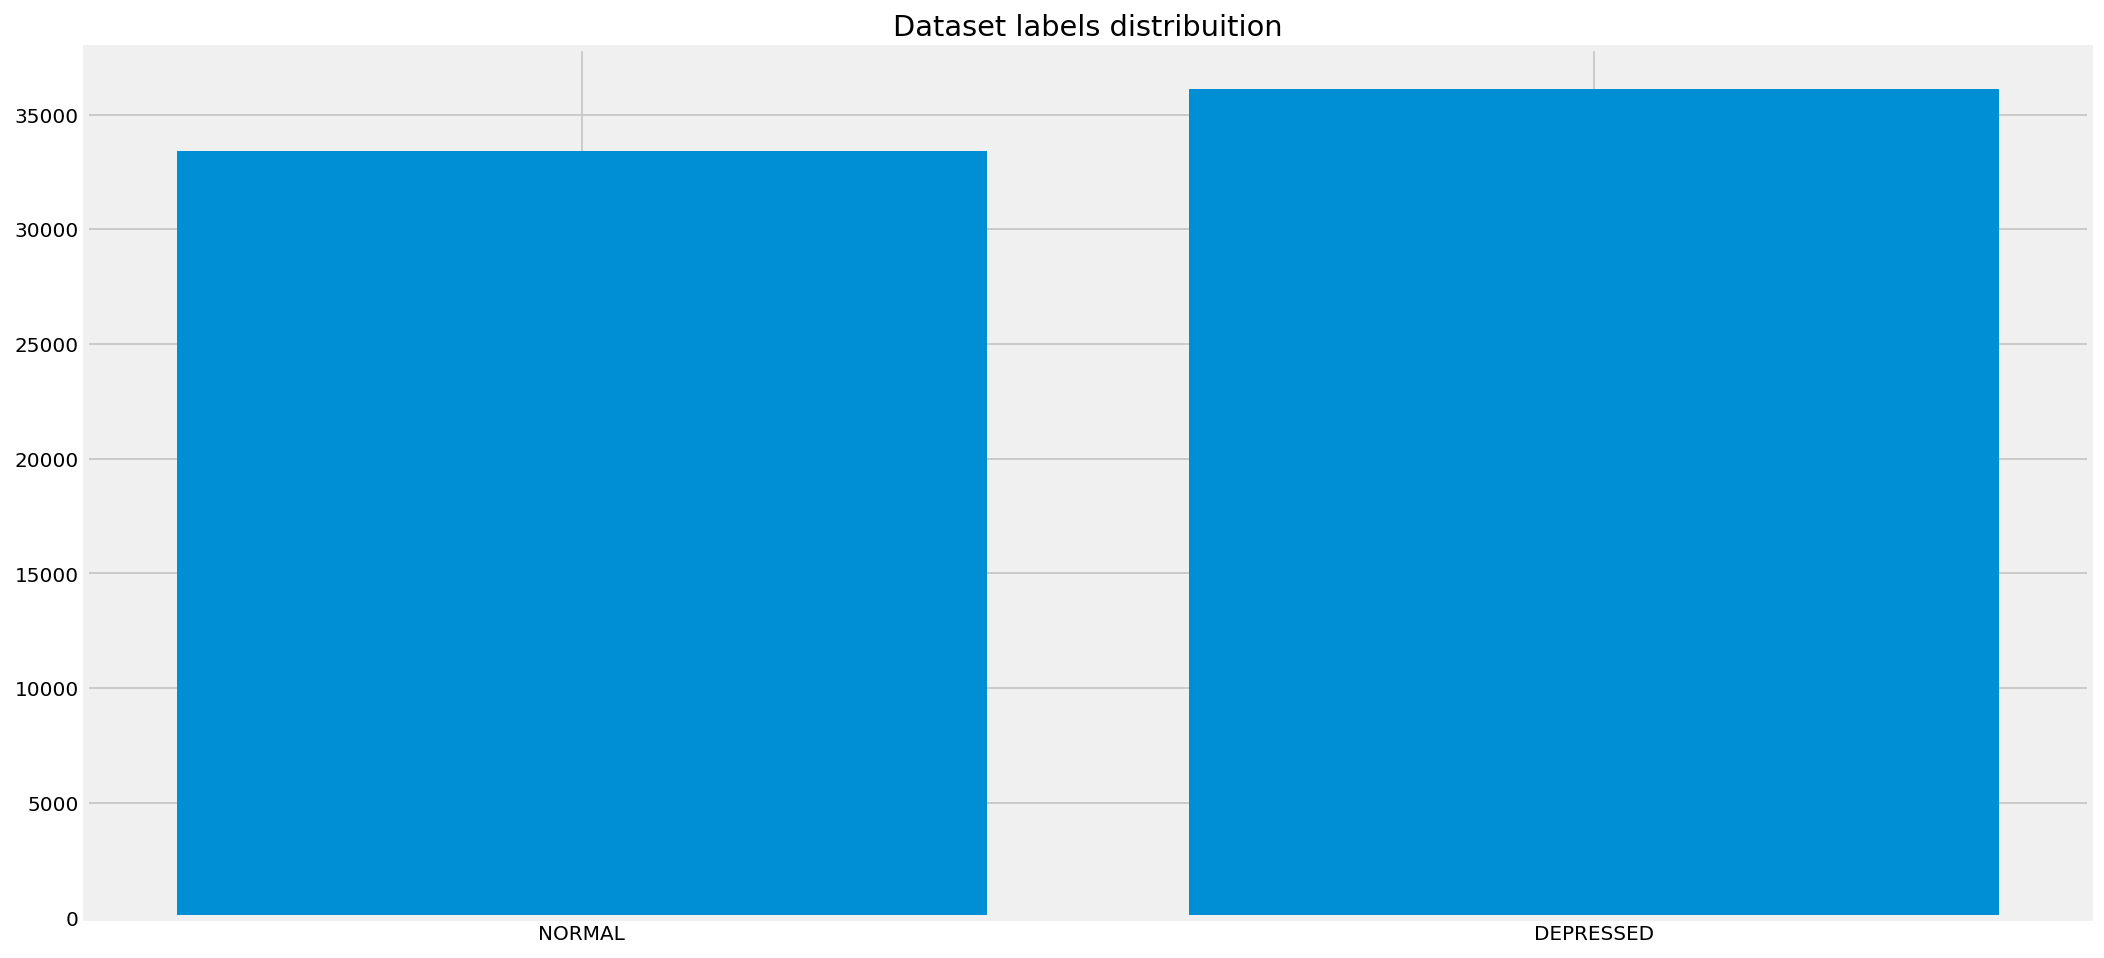

In [10]:
target_cnt = Counter(df.Depressed)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
target_cnt

Counter({'NORMAL': 33437, 'DEPRESSED': 36107})

In [47]:
stop_words = stopwords.words("english") 
lemmatizer = WordNetLemmatizer() 

In [48]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(lemmatizer.lemmatize(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [49]:
df.Body = df.Body.apply(lambda x: preprocess(x))
#df.to_csv('Cap/preprocess_tot_his.csv', encoding='utf-8', index=False)

In [15]:
df=df.drop(['Username','Time', 'Subreddit'], axis = 1) 

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
documents = [_Body.split() for _Body in df_train.Body] 

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

2020-04-29 12:57:52,758 : INFO : collecting all words and their counts
2020-04-29 12:57:52,759 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-29 12:57:52,847 : INFO : PROGRESS: at sentence #10000, processed 415447 words, keeping 29517 word types
2020-04-29 12:57:52,934 : INFO : PROGRESS: at sentence #20000, processed 830335 words, keeping 42650 word types
2020-04-29 12:57:53,022 : INFO : PROGRESS: at sentence #30000, processed 1235503 words, keeping 51618 word types
2020-04-29 12:57:53,129 : INFO : PROGRESS: at sentence #40000, processed 1641174 words, keeping 59261 word types
2020-04-29 12:57:53,211 : INFO : PROGRESS: at sentence #50000, processed 2046357 words, keeping 65763 word types
2020-04-29 12:57:53,276 : INFO : collected 69419 word types from a corpus of 2284175 raw words and 55635 sentences
2020-04-29 12:57:53,277 : INFO : Loading a fresh vocabulary
2020-04-29 12:57:53,318 : INFO : min_count=10 retains 14172 unique words (20% of original 69

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print(vocab_size)

In [21]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

2020-04-29 12:57:53,680 : INFO : training model with 8 workers on 14172 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-04-29 12:57:54,703 : INFO : EPOCH 1 - PROGRESS: at 47.83% examples, 979049 words/s, in_qsize 15, out_qsize 0
2020-04-29 12:57:55,689 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-29 12:57:55,716 : INFO : EPOCH 1 - PROGRESS: at 97.58% examples, 997867 words/s, in_qsize 6, out_qsize 1
2020-04-29 12:57:55,717 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-29 12:57:55,721 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-29 12:57:55,732 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-29 12:57:55,733 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-29 12:57:55,738 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-29 12:57:55,744 : INFO : worker thread finished; awaiting finish of 1

2020-04-29 12:58:10,988 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-29 12:58:11,003 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-29 12:58:11,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-29 12:58:11,007 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-29 12:58:11,018 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-29 12:58:11,024 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-29 12:58:11,025 : INFO : EPOCH - 8 : training on 2284175 raw words (2065887 effective words) took 2.2s, 938899 effective words/s
2020-04-29 12:58:12,030 : INFO : EPOCH 9 - PROGRESS: at 47.96% examples, 991287 words/s, in_qsize 15, out_qsize 0
2020-04-29 12:58:13,029 : INFO : EPOCH 9 - PROGRESS: at 95.73% examples, 987292 words/s, in_qsize 9, out_qsize 1
2020-04-29 12:58:13,065 : INFO : worker thread finished; awaiting finish of 7 more threads

2020-04-29 12:58:27,131 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-29 12:58:27,139 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-29 12:58:27,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-29 12:58:27,149 : INFO : EPOCH 16 - PROGRESS: at 100.00% examples, 1024078 words/s, in_qsize 0, out_qsize 1
2020-04-29 12:58:27,151 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-29 12:58:27,152 : INFO : EPOCH - 16 : training on 2284175 raw words (2065417 effective words) took 2.0s, 1022706 effective words/s
2020-04-29 12:58:28,161 : INFO : EPOCH 17 - PROGRESS: at 49.41% examples, 1020168 words/s, in_qsize 15, out_qsize 0
2020-04-29 12:58:29,109 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-29 12:58:29,125 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-29 12:58:29,129 : INFO : worker thread finished; awaiting finish of 5 more 

2020-04-29 12:58:43,250 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-29 12:58:43,254 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-29 12:58:43,256 : INFO : EPOCH - 24 : training on 2284175 raw words (2065786 effective words) took 2.0s, 1033047 effective words/s
2020-04-29 12:58:44,258 : INFO : EPOCH 25 - PROGRESS: at 48.41% examples, 1000274 words/s, in_qsize 14, out_qsize 1
2020-04-29 12:58:45,219 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-04-29 12:58:45,219 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-04-29 12:58:45,237 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-04-29 12:58:45,246 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-29 12:58:45,257 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-29 12:58:45,259 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-29 12:58:

2020-04-29 12:58:59,524 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-04-29 12:58:59,528 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-04-29 12:58:59,531 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-04-29 12:58:59,539 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-04-29 12:58:59,546 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-04-29 12:58:59,548 : INFO : EPOCH - 32 : training on 2284175 raw words (2065414 effective words) took 2.0s, 1024188 effective words/s
2020-04-29 12:58:59,548 : INFO : training on a 73093600 raw words (66101549 effective words) took 65.9s, 1003610 effective words/s


(66101549, 73093600)

In [22]:
w2v_model.most_similar("love")
w2v_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-04-29 12:58:59,560 : INFO : precomputing L2-norms of word weight vectors
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('jaime', 0.27336159348487854)]

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Body)

vocab_size = len(tokenizer.word_index) + 1

In [24]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Body), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Body), maxlen=300)

In [25]:
labels = df_train.Depressed.unique().tolist()

In [26]:
df_train.groupby('Depressed').size()

Depressed
DEPRESSED    28812
NORMAL       26823
dtype: int64

In [27]:
encoder = LabelEncoder()
encoder.fit(df_train.Depressed.tolist())

y_train = encoder.transform(df_train.Depressed.tolist())
y_test = encoder.transform(df_test.Depressed.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


In [28]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
#print(embedding_matrix.shape)

In [29]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [30]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2020-04-29 12:59:04,555 : WARNING : From C:\Users\asus\Anaconda3\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          20826000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,986,501
Trainable params: 160,501
Non-trainable params: 20,826,000
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [32]:
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)])

Instructions for updating:
Use tf.cast instead.


2020-04-29 12:59:05,578 : WARNING : From C:\Users\asus\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 50071 samples, validate on 5564 samples
Epoch 1/10
50071/50071 [==============================] - 336s 7ms/step - loss: 0.6216 - accuracy: 0.6365 - val_loss: 0.6063 - val_accuracy: 0.6779
Epoch 2/10


C:\Users\asus\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50071/50071 [==============================] - 349s 7ms/step - loss: 0.5790 - accuracy: 0.6710 - val_loss: 0.5927 - val_accuracy: 0.6837
Epoch 3/10
50071/50071 [==============================] - 351s 7ms/step - loss: 0.5652 - accuracy: 0.6813 - val_loss: 0.5765 - val_accuracy: 0.6909
Epoch 4/10
50071/50071 [==============================] - 353s 7ms/step - loss: 0.5560 - accuracy: 0.6864 - val_loss: 0.5781 - val_accuracy: 0.6932
Epoch 5/10
50071/50071 [==============================] - 338s 7ms/step - loss: 0.5519 - accuracy: 0.6897 - val_loss: 0.5642 - val_accuracy: 0.6955
Epoch 6/10
50071/50071 [==============================] - 334s 7ms/step - loss: 0.5456 - accuracy: 0.6961 - val_loss: 0.5669 - val_accuracy: 0.6981
Epoch 7/10
50071/50071 [==============================] - 328s 7ms/step - loss: 0.5425 - accuracy: 0.6968 - val_loss: 0.5546 - val_accuracy: 0.6950
Epoch 8/10
50071/50071 [==============================] - 342s 7ms/step - loss: 0.5383 - accuracy: 0.7008 - val_loss: 0.553

In [33]:
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

13909/13909 [==============================] - 34s 2ms/step

ACCURACY: 0.6978934407234192
LOSS: 0.5518703849158457


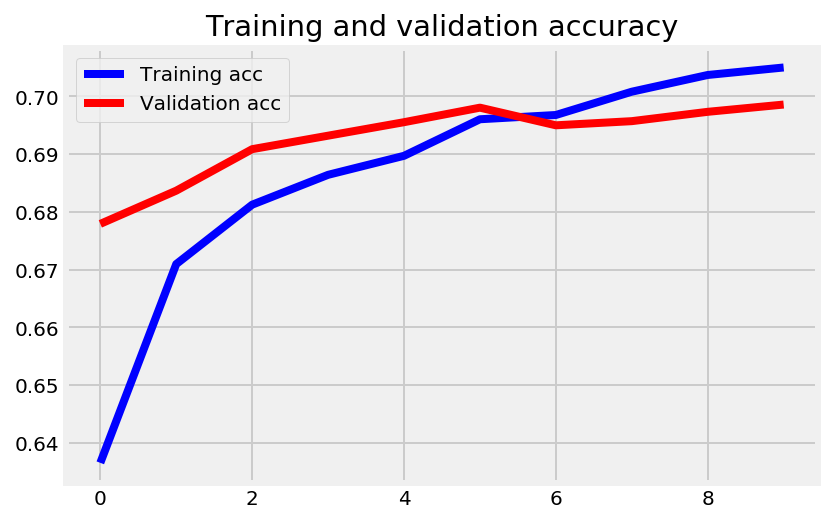

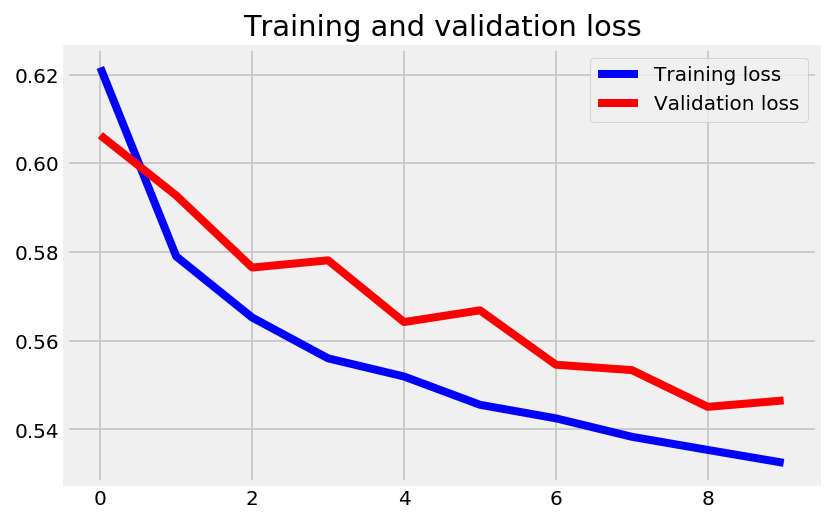

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= 0.4:
            label = "DEPRESSED"
        elif score >= 0.7:
            label = "NORMAL"

        return label
    else:
        return "DEPRESSED" if score < 0.5 else "NORMAL"

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    score = model.predict([x_test])[0]
    label = decode_sentiment(score, include_neutral=False)

    return {"label": label, "score": float(score)} 

In [37]:
predict("Who else is ready to be lonely as fuck on Valentine’s Day? I know I’m not...Honestly tho I hate the person who invented Valentine’s Day.")

{'label': 'DEPRESSED', 'score': 0.023674989119172096}

In [38]:
predict("Who else never believed reading a book could change their life until they eventually read one and it happens.I've always loved reading but none of them had any impact in my life. I always hear others say a particular book changed their reasoning and helped them greatly, I have always seen that idea as lame until i read Paulo Coelho's The Alchemist and Valkyries. Pls recommend other life inspiring books, thanks.")

{'label': 'DEPRESSED', 'score': 0.48120570182800293}

In [39]:
y_pred_1d = []
y_test_1d = list(df_test.Depressed)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

13909/13909 [==============================] - 34s 2ms/step


In [40]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

   DEPRESSED       0.73      0.67      0.70      7295
      NORMAL       0.67      0.73      0.70      6614

   micro avg       0.70      0.70      0.70     13909
   macro avg       0.70      0.70      0.70     13909
weighted avg       0.70      0.70      0.70     13909



In [41]:
accuracy_score(y_test_1d, y_pred_1d)

0.6978934502839887

In [42]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-04-29 13:57:52,392 : INFO : saving Word2Vec object under model.w2v, separately None
2020-04-29 13:57:52,393 : INFO : not storing attribute vectors_norm
2020-04-29 13:57:52,394 : INFO : not storing attribute cum_table
C:\Users\asus\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-04-29 13:57:52,844 : INFO : saved model.w2v


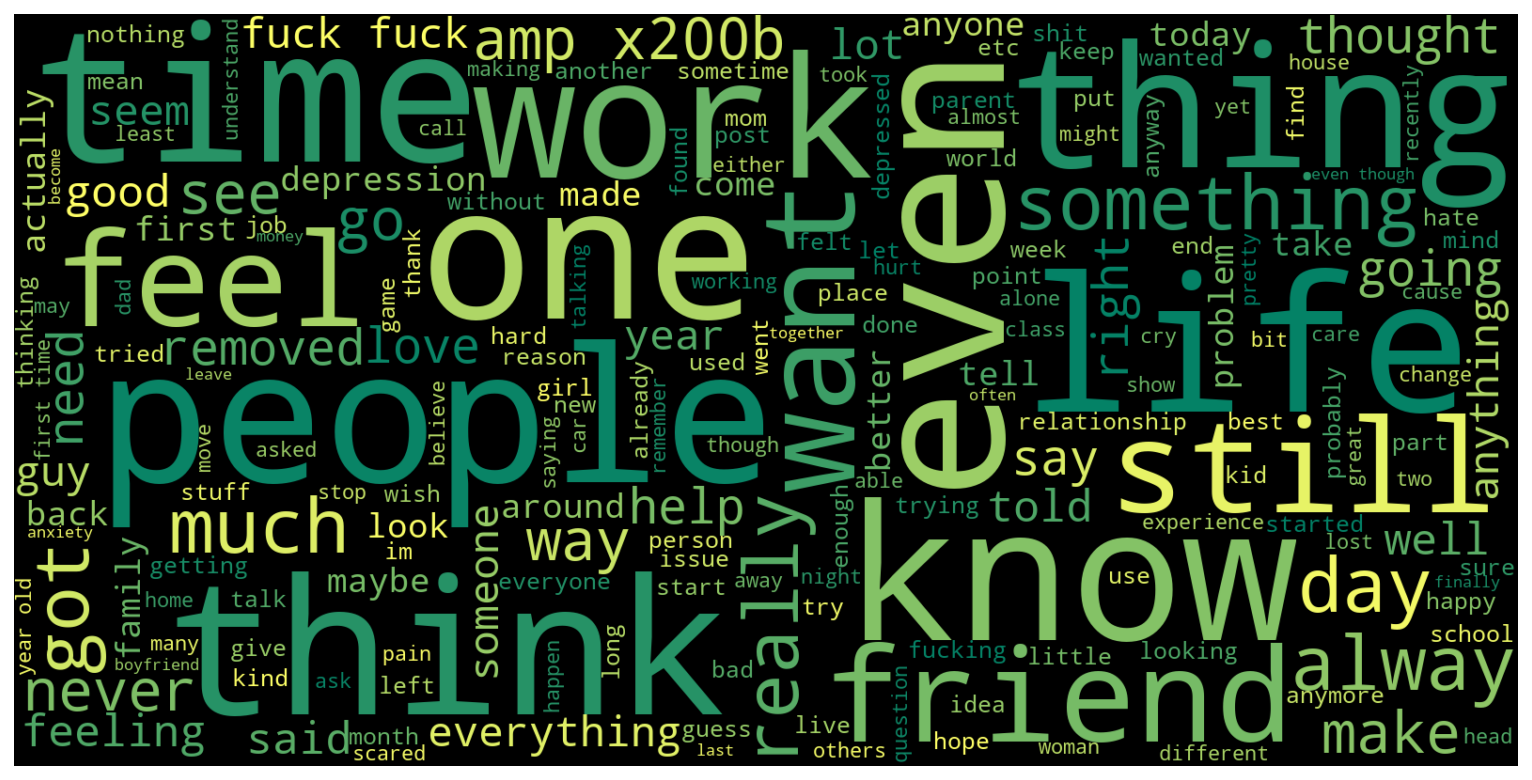

In [43]:
neg_tweets = df[df.Depressed == "DEPRESSED"]
neg_string = []
for t in neg_tweets.Body:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, relative_scaling=0, height=800,max_font_size=200, colormap="summer").generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

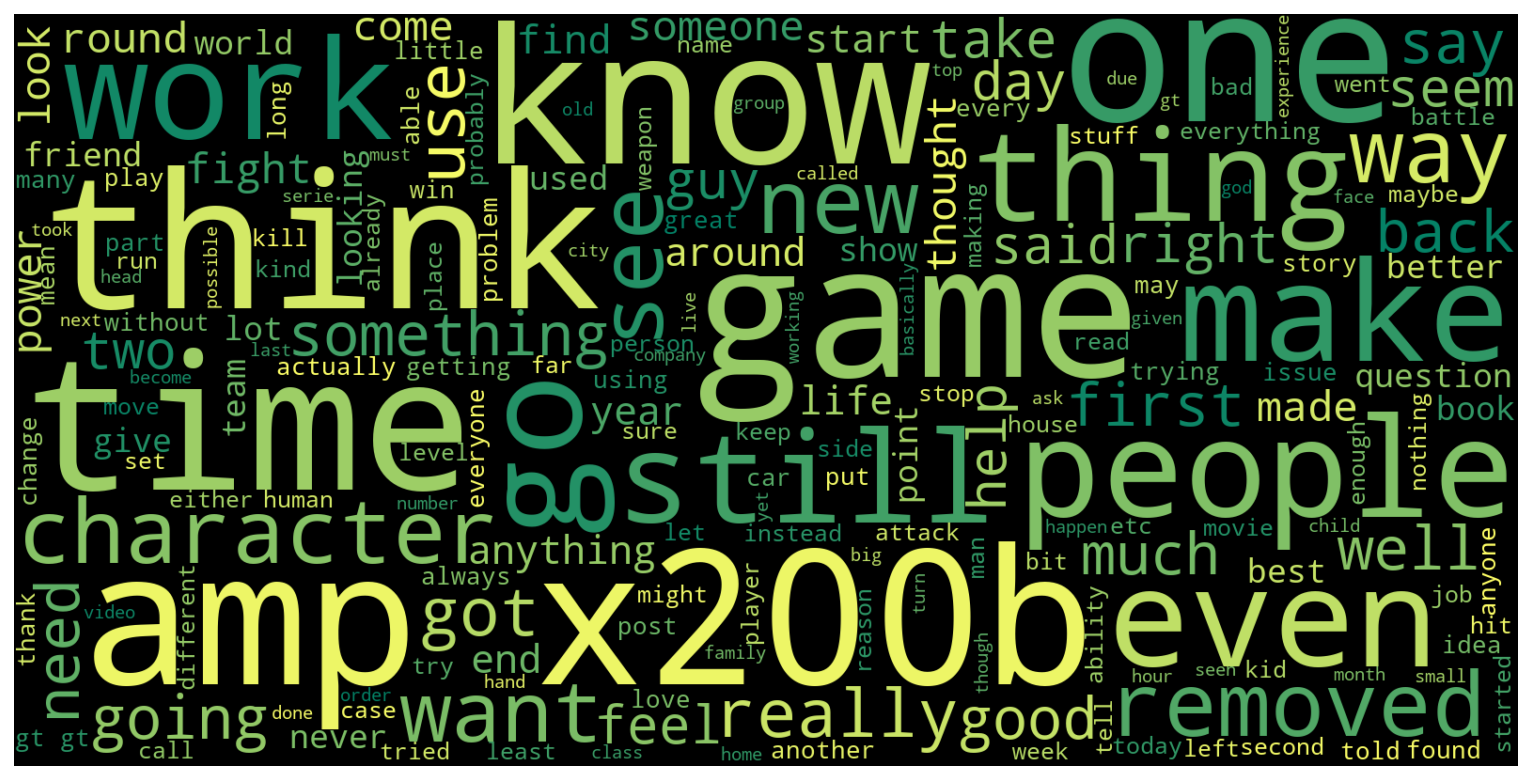

In [44]:
neg_tweets = df[df.Depressed == "NORMAL"]
neg_string = []
for t in neg_tweets.Body:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,relative_scaling=0,colormap='summer').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [45]:
from collections import Counter 
split_it = neg_string.split() 
Counter = Counter(split_it) 
most_occur = Counter.most_common(4)   
print(most_occur) 

[('like', 8619), ('would', 8036), ('get', 7613), ('one', 7534)]
